In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from datetime import timedelta, date
import ast

# Load Data
Load and prepare data for exploratory data analysis.

In [18]:
inputcsv = 'data/generated/working_combined_diaries.csv'
df = pd.read_csv(inputcsv)
df.head(5)

,name,year,letterboxd_uri,rating,rewatch,watched_date,movie_id,language,poster,popularity,vote_average,release_date,genres,origin_country,revenue,runtime,tagline,cast,director
0,Godzilla vs. Kong,2021,https://boxd.it/1PXghH,3.0,NaN,2021-05-03,399566,en,https://image.tmdb.org/t/p/original'/pgqgaUx1c...,123.613,7.618,2021-03-24,"['Action', 'Science Fiction', 'Adventure']",['US'],470116094,114,One will fall.,"[{'name': 'Alexander Skarsgård', 'gender': 2},...",['Adam Wingard']
1,The Woman in the Window,2021,https://boxd.it/1S4UiR,2.5,NaN,2021-05-19,520663,en,https://image.tmdb.org/t/p/original'/wcrjc1uwQ...,20.960,6.020,2021-05-13,"['Crime', 'Mystery', 'Thriller']",['US'],0,102,She has nothing to prove but what's real.,"[{'name': 'Amy Adams', 'gender': 1}, {'name': ...",['Joe Wright']
2,About Time,2013,https://boxd.it/1SLTdH,4.5,NaN,2021-05-24,122906,en,https://image.tmdb.org/t/p/original'/iR1bVfURb...,54.267,7.918,2013-09-04,"['Drama', 'Romance', 'Fantasy']",['GB'],87100449,123,What if every moment in life came with a secon...,"[{'name': 'Domhnall Gleeson', 'gender': 2}, {'...",['Richard Curtis']
3,Pretty Woman,1990,https://boxd.it/1T0ZVb,2.5,NaN,2021-05-26,114,en,https://image.tmdb.org/t/p/original'/dZXpE4Ble...,56.968,7.500,1990-03-23,"['Comedy', 'Romance']",['US'],463406268,119,"She walked off the street, into his life and s...","[{'name': 'Richard Gere', 'gender': 2}, {'name...",['Garry Marshall']
4,The Handmaiden,2016,https://boxd.it/1TZaH5,4.0,NaN,2021-06-02,290098,ko,https://image.tmdb.org/t/p/original'/dLlH4aNHd...,60.195,8.225,2016-06-01,"['Thriller', 'Drama', 'Romance']",['KR'],38600000,145,Never did they expect to get into a controvers...,"[{'name': 'Kim Min-hee', 'gender': 1}, {'name'...",['Park Chan-wook']


There were some issues with date values being in the 2-digit year format, so I converted them to the 4-digit year format in Excel. I also converted the date columns to datetime format.
> Some of the values were incorrect so I had to manually correct them as well. (E.g., 34 != 2034, but 1934 instead)

In [3]:
# Had to manually datetime date columns in Excel bc datetime function sucks
df['watched_date'] = pd.to_datetime(df['watched_date'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')


## KPIs / General Summary of Data

Let's find out some general information about my watch history.

In [4]:
print('KPIs | General Summary of Data')

# Describe timeframe
earliest_entry = min(df['watched_date'])
latest_entry = max(df['watched_date'])
print(f'Timeframe: {earliest_entry} - {latest_entry}')

# Days in between the first and last entry
days_between = (latest_entry - earliest_entry).days
print(f'Days in between the first and last entry: {days_between}\n')

# Number of Entries
count_entries = len(df)
print(f'Entries Count: {count_entries}')

# Watchtime
total_runtime = df['runtime'].sum()
days_total = total_runtime // (24 * 60)
hours_total = (total_runtime % (24 * 60)) // 60
minutes_total = total_runtime % 60
print(f'Total Watchtime: {days_total:.0f} days, {hours_total:.0f} hours, and {minutes_total:.0f} minutes')

# Directors Watched
# Ensure 'director' column values are lists
df['director'] = df['director'].apply(lambda x: tuple(x) if isinstance(x, str) else x)
data_exploded = df.explode('director')
unique_directors = data_exploded['director'].nunique()
print(f'Unique Directors Watched: {unique_directors}')

# Origin Countries Watched
# Ensure 'origin_country' column values are lists
df['origin_country'] = df['origin_country'].apply(lambda x: tuple(x) if isinstance(x, str) else x)
data_exploded = df.explode('origin_country')
unique_countries = data_exploded['origin_country'].nunique()
print(f'Origin Countries: {unique_countries}')

# Average rating rounded to two decimals
with_ratings = df[(df['rating'].notna()) & (df['rating'] != '')]
# Average rating rounded to two decimals
avg_rating = with_ratings['rating'].mean()
print(f"Average rating: {avg_rating:.2f}")

# >1 Film Days
entries_by_date = df.groupby('watched_date').size()
# Filter out the days with more than one movie
days_with_more_than_one_movie = entries_by_date[entries_by_date > 1]
print(f">1 Film Days: {len(days_with_more_than_one_movie)}")

KPIs | General Summary of Data
Timeframe: 2021-05-03 00:00:00 - 2024-05-01 00:00:00
Days in between the first and last entry: 1094

Entries Count: 326
Total Watchtime: 26 days, 1 hours, and 13 minutes
Unique Directors Watched: 62
Origin Countries: 24
Average rating: 3.43
>1 Film Days: 61


In what is essentially 1k days, I feel like I've watched a considerable amount of movies! There are also a lot of days where I watched multiple movies.

# Exploratory Data Analysis
Let's explore the data to see if we can find any interesting patterns or insights.

In [5]:
# Extract the year from the release_date column
df['release_year'] = df['release_date'].dt.year

# Oldest and latest movie watched; title and release date
oldest_movie = df[df['release_date'] == df['release_date'].min()]
latest_movie = df[df['release_date'] == df['release_date'].max()]
print(f'Oldest Movie: {oldest_movie["name"].values[0]} ({oldest_movie["release_date"].values[0]})')
print(f'Latest Movie: {latest_movie["name"].values[0]} ({latest_movie["release_date"].values[0]})')

Oldest Movie: Death Takes a Holiday (1934-03-30T00:00:00.000000000)
Latest Movie: Godzilla x Kong: The New Empire (2024-03-27T00:00:00.000000000)


Decade Release Counts:
release_date
1930      1
1940      2
1970      5
1980      5
1990     29
2000     73
2010    119
2020     92
Name: count, dtype: int64


<Axes: title={'center': 'Decade Release Counts'}, xlabel='release_date'>

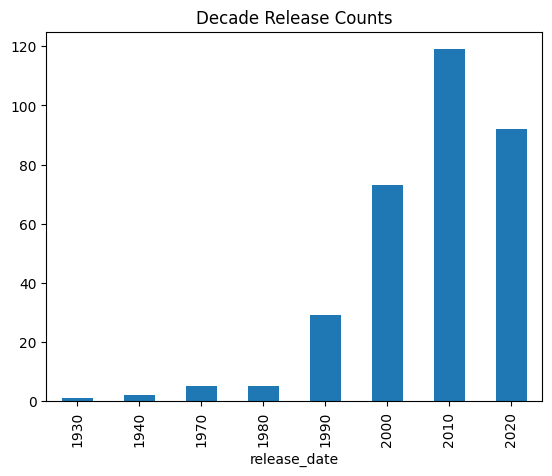

In [6]:
# entries by decade release | count of entries by year bar graph
decade_release_counts = df['release_date'].dt.year // 10 * 10
decade_release_counts = decade_release_counts.value_counts().sort_index()

# Print the sorted decade release counts
print("Decade Release Counts:")
print(decade_release_counts)

# Chart the decade release counts
decade_release_counts.plot(kind='bar',title='Decade Release Counts')

<Axes: title={'center': 'Entries by Year of Release'}, xlabel='release_year'>

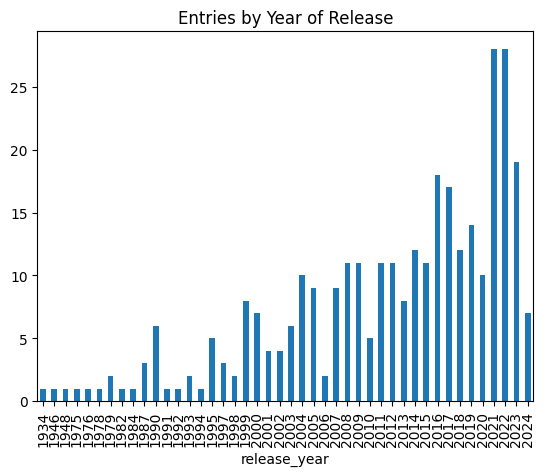

In [7]:
# bar graph of entries by year release
# Count the number of movies watched per year
movies_per_year = df['release_year'].value_counts().sort_index()
movies_per_year.plot(kind='bar', title='Entries by Year of Release')

As expected, I've watched more movies that were released in the last 20 years. Let's now figure out what years within the timeframe I've watched the most movies. I remember 2023 being a movie-heavy year -- I made a conscious effort to watch more movies that year and hit 100 movies. Let's see if that's true.

In [8]:
# number of movies watched per year | month graph each year | count() for weekday
year_counts = df['watched_date'].map(lambda x: x.year).value_counts().sort_index()

month_counts = df['watched_date'].map(lambda x: x.month).value_counts().sort_index()


# Print the sorted year counts
print("Yearly Counts:")
print(year_counts)

# Print the sorted month counts
print("Monthly Counts:")
print(month_counts)

Yearly Counts:
watched_date
2021     65
2022     52
2023    152
2024     57
Name: count, dtype: int64
Monthly Counts:
watched_date
1     57
2     33
3     35
4     47
5     17
6     10
7     19
8     29
9     19
10    18
11    20
12    22
Name: count, dtype: int64


Because of the goal I set for myself in 2023, there was a considerable spike in movies watched. 2024 is also shaping up to be movie-heavy since the data ends May 2024. The first quarter is skewed since this data includes entries from Jan-May 2024. Let's now see my ratings distribution. I'm curious to see if I'm a harsh critic or not.

<Axes: title={'center': 'Count of Ratings'}, xlabel='rating'>

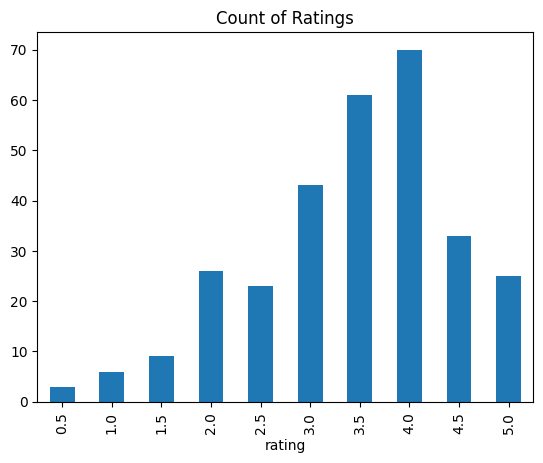

In [9]:
count_with_ratings = with_ratings['rating'].value_counts().sort_index()
# Bar graph of ratings
count_with_ratings.plot(kind='bar', title='Count of Ratings')

I feel like I need to watch more "bad" movies. I'm not sure if I'm a harsh critic or if I just have good taste.

In [10]:
rewatch_count = df[df['rewatch'] == 'Yes'].shape[0]
# Print the count
print(f"Number of rewatches: {rewatch_count}")

newwatch_count = df['rewatch'].isna().sum()
# Print the count
print(f"Number of new watches: {newwatch_count}")

percentage_rewatch = format(rewatch_count / (count_entries),".0%")
print(f'Percentage of rewatches: {percentage_rewatch}')

Number of rewatches: 100
Number of new watches: 226
Percentage of rewatches: 31%


Pretty high rewatch count! Let's see if I rate movies differently on rewatch. 

In [11]:
# List of rewatched films within timeframe; number of occurrences, their watch dates, and their ratings. ordered by name and watched_date
name_counts = df['name'].value_counts()
multiple_occurrences = name_counts[name_counts > 1]
multiple_occurrences_detailed = df[df['name'].isin(multiple_occurrences.index)].sort_values(['name','watched_date'])[['name', 'rating','watched_date']]
print("Ratings for movies I've watched more than once:")
print(multiple_occurrences_detailed)

Ratings for movies I've watched more than once:
                                                  name  rating watched_date
2                                           About Time     4.5   2021-05-24
36                                          About Time     4.5   2021-09-15
224                                     Before Sunrise     5.0   2023-06-21
241                                     Before Sunrise     5.0   2023-09-14
24   Birds of Prey (and the Fantabulous Emancipatio...     3.5   2021-08-13
313  Birds of Prey (and the Fantabulous Emancipatio...     3.0   2024-04-06
12                                Call Me by Your Name     4.5   2021-07-28
80                                Call Me by Your Name     4.5   2022-02-16
14                                    Django Unchained     4.0   2021-08-05
210                                   Django Unchained     4.0   2023-04-27
84                                       Don't Look Up     3.5   2022-04-15
154                                     

I tend to rate movies higher on rewatch. I think this is because I know what to expect and can appreciate the movie more. I also tend to rewatch movies I like, so that could be a factor as well. Except for the movie Imaginary (which is an error in the data), Typically, I've only rewatched movies I've rated more than 3 stars. I think I should rewatch some of the movies I've rated lower to see if my opinion changes, like Downsizing which went from 2.0 to 2.5. Train to Busan lost a star on rewatch, I wonder why. I remember liking it a lot the first time I watched it.

Let's now see what days I watched movies the most. I'm curious to see if I have a movie-watching pattern.

In [12]:
# day when i watched the most amount of movies

most_watched_day = df['watched_date'].mode()

movies_on_most_watched_day = df[df['watched_date'].isin(most_watched_day)]

print(f"Day(s) when the most movies were watched: {most_watched_day.dt.date.values}")
print("Movies watched on those day(s):")
print(movies_on_most_watched_day[['name', 'watched_date','rewatch']])

Day(s) when the most movies were watched: [datetime.date(2021, 7, 3) datetime.date(2023, 11, 2)]
Movies watched on those day(s):
                                                  name watched_date rewatch
5                                          Hello World   2021-07-03     NaN
6                             5 Centimeters per Second   2021-07-03     NaN
7                                           Your Name.   2021-07-03     Yes
8                                             Horimiya   2021-07-03     NaN
249                             The Day After Tomorrow   2023-11-02     Yes
250                      The Day the Earth Stood Still   2023-11-02     Yes
251  Percy Jackson & the Olympians: The Lightning T...   2023-11-02     Yes
252                                       Fire of Love   2023-11-02     NaN


Wow, seems like I had an animation-heavy day on 2021-07-03 ! I also remember the 2nd day to be a particularly lazy one and I wanted to rewatch movies and not delve into new ones. These days, I remember, I set to be a movie marathon day.

In [20]:
# most watched director | max(count(director))

# Ensure 'director' column values are lists
df['director'] = df['director'].apply(lambda x: eval(x) if isinstance(x, str) else x)

director_data_exploded = df.explode('director')

Now that we've prepared our director data, let's see who my favorite directors are.

In [21]:
# Count the occurrences of each director
director_counts = director_data_exploded['director'].value_counts()

# Print the directors watched the most
print("Directors watched the most:")
print(director_counts)

# number of unique directors
unique_directors = director_data_exploded['director'].nunique()
print(f"Number of unique directors: {unique_directors}")

Directors watched the most:
director
Quentin Tarantino    6
Denis Villeneuve     6
Sam Raimi            4
Ridley Scott         4
Matt Reeves          4
                    ..
Alfred Hitchcock     1
Mark Waters          1
Mel Gibson           1
Joel Coen            1
Edgar Wright         1
Name: count, Length: 256, dtype: int64
Number of unique directors: 256


My top directors tend to be style-heavy directors. People who have a distinct style that I particularly enjoy. I'm surprised Edgar Wright isn't in the top. I guess I haven't watched a lot of his movies in this timeframe; I enjoy his direction and typically think of him when I think of comedic editing. Let's see the data for actors now.

In [22]:
# most watched cast | max(count(actor))

# Ensure 'cast' column values are lists of dictionaries
df['cast'] = df['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract actor names from the list of dictionaries
df['cast'] = df['cast'].apply(lambda cast_list: [actor['name'] for actor in cast_list] if isinstance(cast_list, list) else cast_list)

# Explode the 'cast' column to have one actor per row
cast_data_exploded = df.explode('cast')

In [23]:
# Count the occurrences of each actor
actor_counts = cast_data_exploded['cast'].value_counts()
# Print the most watched actors watched at least 8 times; arbitrary number
print("Actors watched the most:")
print(actor_counts[actor_counts >= 8])

Actors watched the most:
cast
Samuel L. Jackson     13
Brad Pitt             12
J.K. Simmons          10
Chris Pratt           10
Scarlett Johansson     9
Willem Dafoe           9
Dave Bautista          9
David Dastmalchian     8
Stan Lee               8
Paul Rudd              8
James Franco           8
Margot Robbie          8
Name: count, dtype: int64


Heavy-hitters for sure. Mostly A-listers which is expected. I finally put a name to the face for some of the actors I've seen in multiple movies (David Dastmalchian!). I'm not surprised to see a lot of Marvel actors in the list. I've watched a lot of Marvel movies in this timeframe. Willem Dafoe is a surprise, I didn't realize I've watched so many movies with him in it. Let's see the data for genres now. 

In [24]:
# Movies with Willem Dafoe
willem_dafoe_movies = cast_data_exploded[cast_data_exploded['cast'] == 'Willem Dafoe']
print("Movies with Willem Dafoe:")
print(willem_dafoe_movies[['name', 'release_date', 'rating']])

# Movies with David Dastmalchian
david_dastmalchian_movies = cast_data_exploded[cast_data_exploded['cast'] == 'David Dastmalchian']
print("Movies with David Dastmalchian:")
print(david_dastmalchian_movies[['name', 'release_date', 'rating']])

Movies with Willem Dafoe:
                             name release_date  rating
62                     Spider-Man   2002-05-01     NaN
63                   Spider-Man 2   2004-06-25     NaN
64                   Spider-Man 3   2007-05-01     NaN
78        Spider-Man: No Way Home   2021-12-15     4.5
129                The Lighthouse   2019-10-18     4.0
187                     John Wick   2014-10-22     3.0
267                 Asteroid City   2023-06-08     4.0
277  Murder on the Orient Express   2017-11-03     3.0
283                   Poor Things   2023-12-07     5.0
Movies with David Dastmalchian:
                                  name release_date  rating
17                   The Suicide Squad   2021-07-28     3.5
22                             Ant-Man   2015-07-14     3.0
25                     The Dark Knight   2008-07-16     5.0
46                   Blade Runner 2049   2017-10-04     3.5
57                                Dune   2021-09-15     3.5
172  Ant-Man and the Wasp: Quant

Let's explode the genres column and see what genres I watch the most.

In [25]:
# by genre

# Ensure 'genres' column values are lists
df['genres'] = df['genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)

genre_data_exploded = df.explode('genres')

In [26]:
# Count the occurrences of each genre
genre_counts = genre_data_exploded['genres'].value_counts()

# Calculate the average rating for each genre
genre_ratings = genre_data_exploded.groupby('genres')['rating'].mean()

# Create a DataFrame from genre_counts to merge
genre_counts_df = genre_counts.to_frame(name='count')

# Merge the counts with the average ratings
combined_data = genre_counts_df.merge(genre_ratings, on='genres')

# Sort the combined data by the count of genres in descending order
combined_data_sorted = combined_data.sort_values('count', ascending=False)

# Print the genres watched the most with their average rating
print("Genres watched the most with average ratings:")
print(combined_data_sorted)


Genres watched the most with average ratings:
                 count    rating
genres                          
Drama              141  3.683824
Comedy             129  3.326087
Action              85  3.317568
Science Fiction     77  3.260563
Adventure           74  3.375000
Romance             72  3.291045
Thriller            57  3.281818
Crime               48  3.465909
Fantasy             40  3.500000
Mystery             27  3.333333
Animation           24  3.595238
Horror              21  3.190476
Family              20  3.764706
History             11  3.818182
War                  9  3.888889
Documentary          5  3.500000
Western              4  3.875000
Music                4  3.875000


Dramas and Comedies I've watched the most! As expected, Horror is pretty far down since I'm not the biggest fan. I really need to watch more Documentaries and Westerns.

In [27]:
# Ensure 'origin_country' column values are lists
df['origin_country'] = df['origin_country'].apply(lambda x: eval(x) if isinstance(x, str) else x)

country_data_exploded = df.explode('origin_country')

In [28]:
# Count the occurrences of each origin country
country_counts = country_data_exploded['origin_country'].value_counts()

# Print the origin countries watched the most
print("Origin Countries watched the most:")
print(country_counts)

Origin Countries watched the most:
origin_country
US    279
GB     33
PH     12
JP      8
CA      7
FR      4
KR      4
DE      4
ES      3
NZ      2
TW      2
CN      1
TH      1
FI      1
AT      1
IE      1
IT      1
AU      1
Name: count, dtype: int64


As expected, most movies originate from the US. I should watch more PH movies to support local cinema.

In [29]:
# do I watch generally popular movies? what is the least popular movie I've watched?
avg_popularity = df['popularity'].mean()
min_popularity = df['popularity'].min()

least_popular_movie = df[df['popularity'] == min_popularity]

print("Average popularity:")
print(avg_popularity)

print("\nLeast popularity:")
print(min_popularity)
print("\nLeast popular movie watched:")
print(least_popular_movie['name'])


Average popularity:
107.15149999999998

Least popularity:
0.045

Least popular movie watched:
209    Hunger
Name: name, dtype: object


In [30]:
# do I watch generally highly-rated movies? what is the lowest rating movie I've watched?

# Remove rows with 0 vote_average
vote_filtered_data = df[df['vote_average'] != 0]

# Calculate the average, minimum, and maximum ratings
avg_rating = vote_filtered_data['vote_average'].mean()
min_rating = vote_filtered_data['vote_average'].min()
max_rating = vote_filtered_data['vote_average'].max()

# Find the highest and lowest rated movies
highest_rating_movie = vote_filtered_data[vote_filtered_data['vote_average'] == max_rating]['name']
lowest_rating_movie = vote_filtered_data[vote_filtered_data['vote_average'] == min_rating]['name']

# Print the results
print("Average vote:")
print(avg_rating)

print(f"\nHighest rated movie watched with {max_rating} rating:")
print(highest_rating_movie.values)

print(f"\nLowest rated movie watched with {min_rating} rating:")
print(lowest_rating_movie.values)

Average vote:
7.169236923076924

Highest rated movie watched with 9.0 rating:
['Horimiya']

Lowest rated movie watched with 4.5 rating:
['Pinoy Sunday']


vote_average seems to be untrustworthy data, so might as well just ignore it. Let's see some data on movies I've rated 4.5 and above.

# Personal High Ratings
Let's explore the movies I've rated 4.5 and above. I'm curious to see if there are any patterns or if I can find any interesting insights.

In [31]:
personal_high_ratings = df[df['rating'] >= 4.5]

In [32]:
# Explode the 'genres' column to have one genre per row
personal_high_ratings_genre_data_exploded = personal_high_ratings.explode('genres')

# Count the occurrences of each genre
personal_high_ratings_genre_counts = personal_high_ratings_genre_data_exploded['genres'].value_counts()

# Add data from genre_counts that adds count of all genres and the percentage of highly rated movies
personal_high_ratings_genre_counts_df = personal_high_ratings_genre_counts.to_frame(name='count')
personal_high_ratings_genre_counts_df['percentage'] = (personal_high_ratings_genre_counts_df['count'] / genre_counts) * 100

# Print the PHR genres watched the most w/ percentage of all genres watched
print("Personal High Ratings; Genres watched the most:")
print(personal_high_ratings_genre_counts_df.sort_values('percentage', ascending=False))

Personal High Ratings; Genres watched the most:
                 count  percentage
genres                            
Music                2   50.000000
War                  4   44.444444
History              3   27.272727
Mystery              7   25.925926
Family               5   25.000000
Drama               33   23.404255
Animation            5   20.833333
Romance             14   19.444444
Crime                9   18.750000
Thriller            10   17.543860
Fantasy              7   17.500000
Science Fiction     11   14.285714
Action              12   14.117647
Comedy              18   13.953488
Adventure            9   12.162162
Horror               2    9.523810


Despite the low count, Music genre seems to be better rated when compared to the total genre count. Same with War, History, and Mystery. Maybe these are genres I should watch more of. Let's see PHR data for directors.

In [34]:
personal_high_ratings_director_data_exploded = personal_high_ratings.explode('director')
# Count the occurrences of each director, add data from director_counts that adds count of all directors and the percentage of highly rated movies
personal_high_ratings_director_counts = personal_high_ratings_director_data_exploded['director'].value_counts()
personal_high_ratings_director_counts_df = personal_high_ratings_director_counts.to_frame(name='count')
personal_high_ratings_director_counts_df['percentage'] = (personal_high_ratings_director_counts_df['count'] / director_counts) * 100
personal_high_ratings_director_counts_df = personal_high_ratings_director_counts_df.sort_values(by=['count', 'percentage'], ascending=[False, False])
# Print the directors watched the most
print("Personal High Ratings; Directors watched the most:")
print(personal_high_ratings_director_counts_df.head(20))

Personal High Ratings; Directors watched the most:
                    count  percentage
director                             
Christopher Nolan       3   75.000000
Richard Linklater       3   75.000000
Luca Guadagnino         2  100.000000
Richard Curtis          2   66.666667
Denis Villeneuve        2   33.333333
Lin-Manuel Miranda      1  100.000000
Jordan Peele            1  100.000000
Pete Docter             1  100.000000
Dan Scanlon             1  100.000000
Tom Gormican            1  100.000000
Gil Portes              1  100.000000
Jason Woliner           1  100.000000
Craig Gillespie         1  100.000000
Ryan Coogler            1  100.000000
Anthony Russo           1  100.000000
Joe Russo               1  100.000000
John Hughes             1  100.000000
George Miller           1  100.000000
Joe Johnston            1  100.000000
Éric Toledano           1  100.000000


Richard Linklater feels correct. I loved the Before Trilogy. Quentin Tarantino was at the top for director_counts, but he only has 1 movie in the 4.5+ rating. I guess I don't rate his movies super high. Let's see the same data for actors.

In [35]:
personal_high_ratings_actor_data_exploded = personal_high_ratings.explode('cast')
# Count the occurrences of each actor, add data from actor_counts that adds count of all actors and the percentage of highly rated movies
personal_high_ratings_actor_counts = personal_high_ratings_actor_data_exploded['cast'].value_counts()
personal_high_ratings_actor_counts_df = personal_high_ratings_actor_counts.to_frame(name='count')
personal_high_ratings_actor_counts_df['percentage'] = (personal_high_ratings_actor_counts_df['count'] / actor_counts) * 100
personal_high_ratings_actor_counts_df = personal_high_ratings_actor_counts_df.sort_values(by=['count', 'percentage'], ascending=[False, False])

# Print the actors watched the most
print("Personal High Ratings; Actors watched the most:")
print(personal_high_ratings_actor_counts_df[personal_high_ratings_actor_counts>=3])

Personal High Ratings; Actors watched the most:
                    count  percentage
cast                                 
Michael Stuhlbarg       4   80.000000
Ethan Hawke             4   80.000000
Jake Gyllenhaal         4   57.142857
Dave Bautista           4   44.444444
Linda Cardellini        3  100.000000
Kyle Bornheimer         3  100.000000
Haruka Abe              3  100.000000
Tom Stourton            3   75.000000
Julie Delpy             3   75.000000
Angela Bassett          3   75.000000
Domhnall Gleeson        3   75.000000
Tom Holland             3   60.000000
Bradley Cooper          3   50.000000
Terry Notary            3   42.857143
Timothée Chalamet       3   42.857143
Scarlett Johansson      3   33.333333
Chris Pratt             3   30.000000
Brad Pitt               3   25.000000
Samuel L. Jackson       3   23.076923


/var/folders/zc/y15z5jlx6sdg3444ndgx0v5r0000gn/T/ipykernel_22854/3912458172.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(personal_high_ratings_actor_counts_df[personal_high_ratings_actor_counts>=3])


Despite Samuel L. Jackson being in a lot of movies, he's not rated very highly. I think this is because he's in a lot of movies; some of them are bound to be bad. Linda Cardellini, Kyle Bornheimer, and Haruka Abe I'm not aware of, but in the three movies I saw her in, I rated them highly. I should seek more of their movies.

# Conclusion
This was a fun exercise! I learned a lot about my movie-watching habits and what I should watch more of. I'd love to delve into more of the generated columns from TMDb. Make sure to check my [Tableau dashboard](https://public.tableau.com/views/LetterboxdAll-TimeStats/Summary?:language=en-US&:sid=&:display_count=n&:origin=viz_share_link) for more insights and visualizations of this dataset.